In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from myutils.common import yaml_util
from utils import module_util, net_measure_util

In [2]:
config_file_path = '../config/densenet169.yaml'
config = yaml_util.load_yaml_file(config_file_path)
input_shape = config['input_shape']
model = module_util.get_model(config, 'cpu')

In [3]:
modules = list()
module_util.extract_decomposable_modules(model, torch.rand(input_shape).unsqueeze(0), modules)

(tensor([[ 0.1668, -0.2157, -0.2371,  0.0375,  0.0057,  0.3432, -0.2502, -0.0441,
          -0.2477, -0.2335, -0.2904,  0.3285,  0.4263, -0.1867, -0.8052, -0.2192,
           0.1293,  0.2838, -0.1621,  0.3059,  0.1571, -0.5427, -0.1055,  0.2120,
           0.5467, -0.4157,  0.4674, -0.4465,  0.0047,  0.4051, -0.2706, -0.4259,
          -0.1650,  0.0708,  0.1275,  0.2481, -0.2378,  0.5834,  0.3748, -0.0479,
          -0.1313,  0.1390,  0.0165,  0.0061, -0.1928,  0.2545,  0.1600, -0.1687,
          -0.0211,  0.0108,  0.1602, -0.1491,  0.3373, -0.0944,  0.0339,  0.3925,
          -0.7109,  0.0847,  0.1375,  0.0470, -0.2460,  0.3457, -0.0185, -0.2343,
          -0.0206, -0.2268,  0.0237,  0.3688, -0.1930, -0.4467,  0.0768,  0.1979,
          -0.3023, -0.4932,  0.2966, -0.0200,  0.3145, -0.1019,  0.1799, -0.0838,
           0.7537,  0.1127, -0.2179,  0.0693, -0.7945, -0.1273, -0.3886,  0.1995,
           0.0972, -0.0966,  0.2483,  0.3229, -0.5520, -0.3695,  0.4651,  0.0953,
           0.203

In [4]:
for i, module in enumerate(modules):
    print(i, type(module).__name__)

0 Conv2d
1 BatchNorm2d
2 ReLU
3 MaxPool2d
4 _DenseLayer
5 _DenseLayer
6 _DenseLayer
7 _DenseLayer
8 _DenseLayer
9 _DenseLayer
10 BatchNorm2d
11 ReLU
12 Conv2d
13 AvgPool2d
14 _DenseLayer
15 _DenseLayer
16 _DenseLayer
17 _DenseLayer
18 _DenseLayer
19 _DenseLayer
20 _DenseLayer
21 _DenseLayer
22 _DenseLayer
23 _DenseLayer
24 _DenseLayer
25 _DenseLayer
26 BatchNorm2d
27 ReLU
28 Conv2d
29 AvgPool2d
30 _DenseLayer
31 _DenseLayer
32 _DenseLayer
33 _DenseLayer
34 _DenseLayer
35 _DenseLayer
36 _DenseLayer
37 _DenseLayer
38 _DenseLayer
39 _DenseLayer
40 _DenseLayer
41 _DenseLayer
42 _DenseLayer
43 _DenseLayer
44 _DenseLayer
45 _DenseLayer
46 _DenseLayer
47 _DenseLayer
48 _DenseLayer
49 _DenseLayer
50 _DenseLayer
51 _DenseLayer
52 _DenseLayer
53 _DenseLayer
54 _DenseLayer
55 _DenseLayer
56 _DenseLayer
57 _DenseLayer
58 _DenseLayer
59 _DenseLayer
60 _DenseLayer
61 _DenseLayer
62 BatchNorm2d
63 ReLU
64 Conv2d
65 AvgPool2d
66 _DenseLayer
67 _DenseLayer
68 _DenseLayer
69 _DenseLayer
70 _DenseLayer
7

In [5]:
def find_bottleneck_layers(x, start_idx, modules):
    bottleneck_list = list()
    org_size = np.prod(x.size())
    for i in range(start_idx, len(modules)):
        teacher_model = nn.Sequential(*modules[start_idx:i])
        z = teacher_model(x)
        rate = np.prod(z.size()) / org_size
        if rate < 1.0:
            bottleneck_list.append((i, type(modules[i]).__name__, rate, z.size()))
    return bottleneck_list

In [6]:
x = torch.ones(1, *input_shape)
start_idx = 0
end_idx = 14
teacher_model = nn.Sequential(*modules[start_idx:end_idx])
z = teacher_model(x)
z.size()

torch.Size([1, 128, 28, 28])

In [7]:
student_model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, kernel_size=2, stride=1, bias=False),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
)
z = student_model(x)
z.size()

torch.Size([1, 128, 28, 28])

In [8]:
find_bottleneck_layers(x, start_idx, modules)

[(14, '_DenseLayer', 0.6666666666666666, torch.Size([1, 128, 28, 28])),
 (15, '_DenseLayer', 0.8333333333333334, torch.Size([1, 160, 28, 28])),
 (30, '_DenseLayer', 0.3333333333333333, torch.Size([1, 256, 14, 14])),
 (31, '_DenseLayer', 0.375, torch.Size([1, 288, 14, 14])),
 (32, '_DenseLayer', 0.4166666666666667, torch.Size([1, 320, 14, 14])),
 (33, '_DenseLayer', 0.4583333333333333, torch.Size([1, 352, 14, 14])),
 (34, '_DenseLayer', 0.5, torch.Size([1, 384, 14, 14])),
 (35, '_DenseLayer', 0.5416666666666666, torch.Size([1, 416, 14, 14])),
 (36, '_DenseLayer', 0.5833333333333334, torch.Size([1, 448, 14, 14])),
 (37, '_DenseLayer', 0.625, torch.Size([1, 480, 14, 14])),
 (38, '_DenseLayer', 0.6666666666666666, torch.Size([1, 512, 14, 14])),
 (39, '_DenseLayer', 0.7083333333333334, torch.Size([1, 544, 14, 14])),
 (40, '_DenseLayer', 0.75, torch.Size([1, 576, 14, 14])),
 (41, '_DenseLayer', 0.7916666666666666, torch.Size([1, 608, 14, 14])),
 (42, '_DenseLayer', 0.8333333333333334, torch.

Number of Operations: 3399.00887M


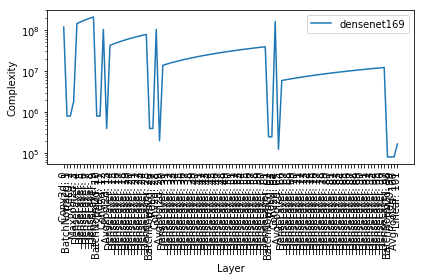

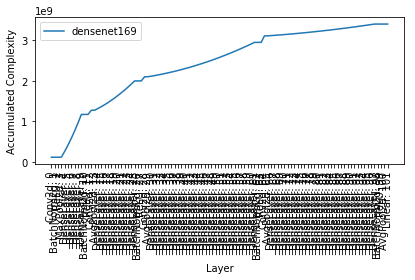

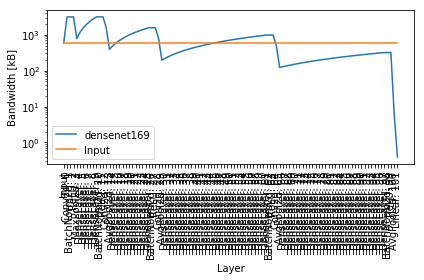

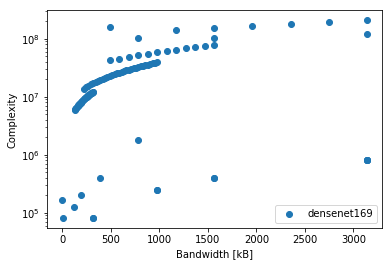

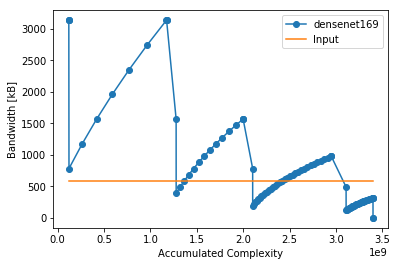

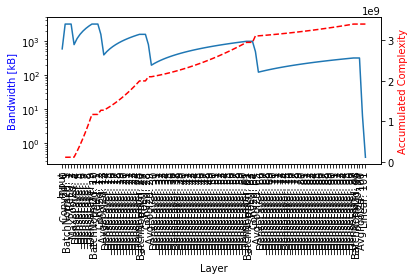

In [9]:
op_count_list, bandwidths, accum_complexities = net_measure_util.compute_model_complexity_and_bandwidth(model, config['model']['type'], input_shape, scaled=False)

Number of Operations: 221.35194M


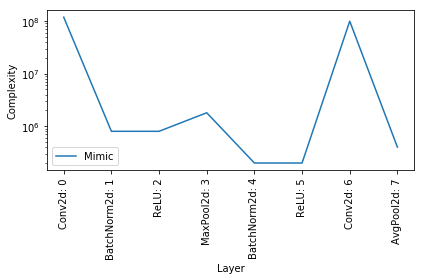

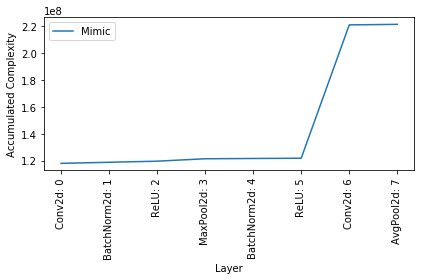

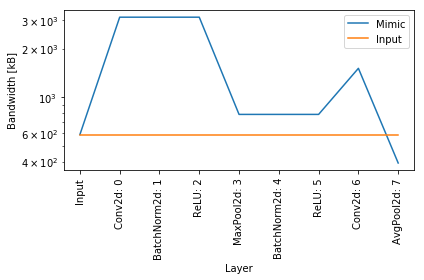

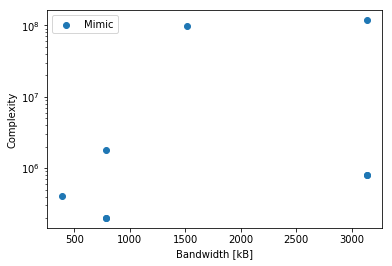

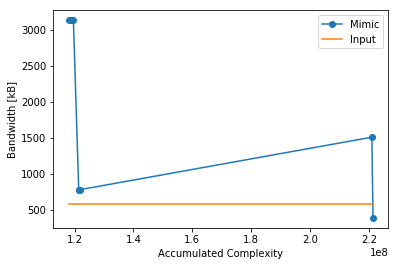

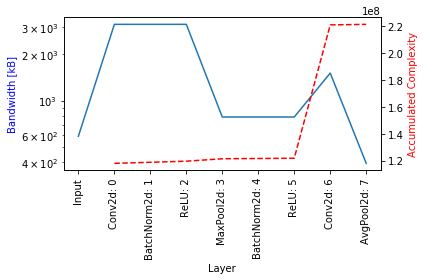

In [10]:
_ = net_measure_util.compute_model_complexity_and_bandwidth(student_model, 'Mimic', input_shape, scaled=False)